## Random Forest Baseline (60/20/20 split)




In [23]:
import numpy as np
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve, roc_curve
)
from sklearn.ensemble import RandomForestClassifier

import joblib

RANDOM_STATE = 42


### Step 1: Load Dataset

In [3]:
DATA_PATH = Path('churn_clean.csv')
df = pd.read_csv(DATA_PATH)
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Step 2: Inspect Target Distribution

In [4]:
def class_count(a):
    counter = Counter(a)
    summary = (
        pd.Series(counter, name='Count')
        .reset_index()
        .rename(columns={'index': 'Exited'})
    )
    summary['Percent'] = (summary['Count'] / len(a) * 100).round(2)
    return summary.sort_values('Count', ascending=False).reset_index(drop=True)

class_count(df['Exited'])


,Exited,Count,Percent
0,0,7963,79.63
1,1,2037,20.37


### Step 3: Feature Preparation & 60/20/20 Split

In [5]:
X = df.drop('Exited', axis=1)
y = df['Exited']

cat_columns = X.select_dtypes(include='object').columns.tolist()
num_columns = X.select_dtypes(exclude='object').columns.tolist()
cat_columns, num_columns


(['Geography', 'Gender'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'])

In [6]:
# First split: 60% train, 40% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=RANDOM_STATE
)

# Second split: 20% validation, 20% test overall
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print('Training set:', X_train.shape, 'Target ratio:', y_train.mean().round(3))
print('Validation set:', X_val.shape, 'Target ratio:', y_val.mean().round(3))
print('Test set:', X_test.shape, 'Target ratio:', y_test.mean().round(3))


Training set: (6000, 10) Target ratio: 0.204
Validation set: (2000, 10) Target ratio: 0.204
Test set: (2000, 10) Target ratio: 0.204


### Step 4: Preprocess Features

In [7]:
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer([
    ('categorical', ohe, cat_columns),
    ('numeric', StandardScaler(), num_columns)
])

preprocess.fit(X_train)

X_train_prepared = preprocess.transform(X_train)
X_val_prepared = preprocess.transform(X_val)
X_test_prepared = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()
X_train_prepared.shape


(6000, 13)

### Step 5: Train Random Forest

In [8]:
rf_clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced_subsample',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_clf.fit(X_train_prepared, y_train)
rf_clf


,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Step 6: Validation & Test Evaluation

In [9]:
y_val_pred = rf_clf.predict(X_val_prepared)
y_val_proba = rf_clf.predict_proba(X_val_prepared)[:, 1]
y_test_pred = rf_clf.predict(X_test_prepared)
y_test_proba = rf_clf.predict_proba(X_test_prepared)[:, 1]


In [10]:
print('Validation ROC-AUC:', round(roc_auc_score(y_val, y_val_proba), 3))
print(classification_report(y_val, y_val_pred))
print('Test ROC-AUC:', round(roc_auc_score(y_test, y_test_proba), 3))
print(classification_report(y_test, y_test_pred))


Validation ROC-AUC: 0.865
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1592
           1       0.77      0.47      0.58       408

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000

Test ROC-AUC: 0.843
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.74      0.44      0.55       407

    accuracy                           0.85      2000
   macro avg       0.81      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



In [11]:
val_cm = confusion_matrix(y_val, y_val_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
val_cm, test_cm


(array([[1534,   58],
        [ 218,  190]]),
 array([[1530,   63],
        [ 227,  180]]))

### Step 7: Visual Diagnostics

In [12]:
FIG_DIR = Path('figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [13]:
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)
val_auc = roc_auc_score(y_val, y_val_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

val_prec, val_rec, _ = precision_recall_curve(y_val, y_val_proba)
test_prec, test_rec, _ = precision_recall_curve(y_test, y_test_proba)
val_ap = average_precision_score(y_val, y_val_proba)
test_ap = average_precision_score(y_test, y_test_proba)


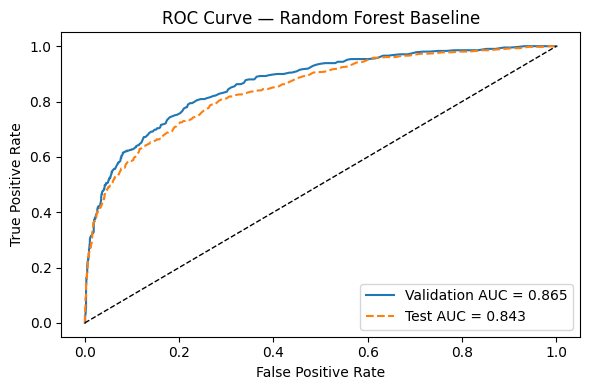

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(val_fpr, val_tpr, label=f'Validation AUC = {val_auc:.3f}')
plt.plot(test_fpr, test_tpr, label=f'Test AUC = {test_auc:.3f}', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Random Forest Baseline')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve_rf_baseline.png', dpi=200)
plt.show()


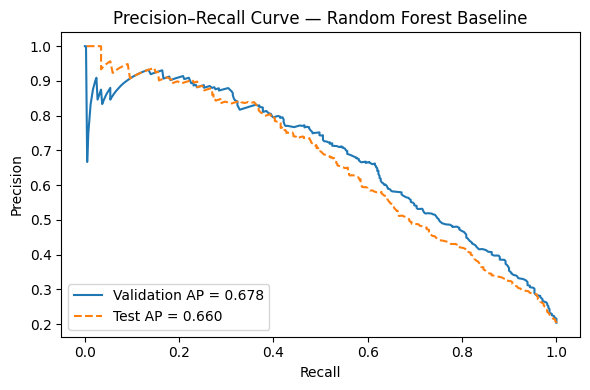

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(val_rec, val_prec, label=f'Validation AP = {val_ap:.3f}')
plt.plot(test_rec, test_prec, label=f'Test AP = {test_ap:.3f}', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve — Random Forest Baseline')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(FIG_DIR / 'pr_curve_rf_baseline.png', dpi=200)
plt.show()


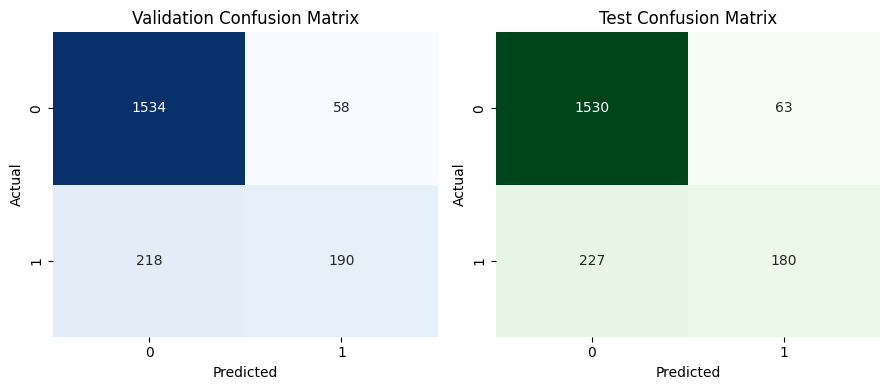

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Validation Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrices_rf_baseline.png', dpi=200)
plt.show()


### Step 8: Feature Importance

In [17]:
feature_importances = pd.Series(rf_clf.feature_importances_, index=feature_names)
top_features = feature_importances.sort_values(ascending=False).head(20)
top_features


numeric__Age                      0.252872
numeric__EstimatedSalary          0.140583
numeric__Balance                  0.138118
numeric__CreditScore              0.135085
numeric__NumOfProducts            0.123252
numeric__Tenure                   0.084508
numeric__IsActiveMember           0.035495
categorical__Geography_Germany    0.024371
numeric__HasCrCard                0.019181
categorical__Geography_France     0.013195
categorical__Gender_Female        0.011488
categorical__Geography_Spain      0.010955
categorical__Gender_Male          0.010899
dtype: float64

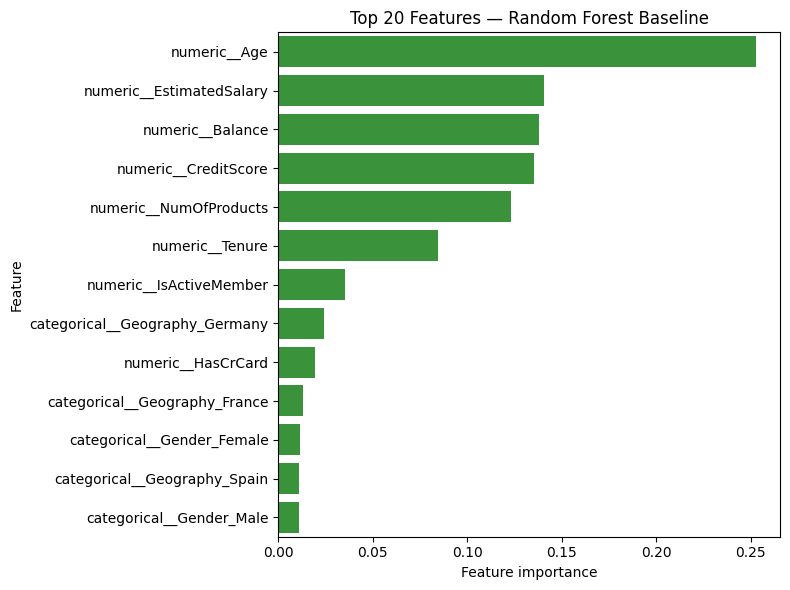

In [18]:
plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, color='tab:green')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Top 20 Features — Random Forest Baseline')
plt.tight_layout()
plt.show()


### Step 9: Persist the Model

In [19]:
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / 'rf_baseline.joblib'
joblib.dump({'model': rf_clf, 'preprocess': preprocess}, MODEL_PATH)
MODEL_PATH


PosixPath('models/rf_baseline.joblib')